# analyze_fit_us_data.ipynb

Analyze the curves that [fit_us_data.ipynb](./fit_us_data.ipynb) fit to the COVID-19 time series.

Inputs:
* `outputs/us_counties_curves.csv`: Curves generated by [fit_us_data.ipynb](./fit_us_data.ipynb)
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

In [2]:
# Read in the CSV file and apply the saved type information
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")

# Read column type metadata
with open(meta_file) as f:
    curves_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
curves_meta["Date"] = "object"

curves_vertical = (
    pd
    .read_csv(csv_file, dtype=curves_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
curves_vertical

State    County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                      
1001  2020-03-10  Alabama   Autauga       55869        0.0              False   
      2020-03-11  Alabama   Autauga       55869        0.0              False   
      2020-03-12  Alabama   Autauga       55869        0.0              False   
      2020-03-13  Alabama   Autauga       55869        0.0              False   
      2020-03-14  Alabama   Autauga       55869        0.0              False   
...                   ...       ...         ...        ...                ...   
56043 2020-09-10  Wyoming  Washakie        7805      111.0              False   
      2020-09-11  Wyoming  Washakie        7805      111.0              False   
      2020-09-12  Wyoming  Washakie        7805      111.0              False   
      2020-09-13  Wyoming  Washakie        7805      111.0              False   
      2020-09-14  Wyoming  Washakie        7805      111.0              False   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1001  2020-03-10     1.000000    8.534081    1.991856  
      2020-03-11     1.042005    8.884457    2.122546  
      2020-03-12     1.085773    9.249130    2.261728  
      2020-03-13     1.131381    9.628679    2.409942  
      2020-03-14     1.178904   10.023702    2.567768  
...                       ...         ...         ...  
56043 2020-09-10   140.526425  117.290527  116.319431  
      2020-09-11   144.354589  118.657346  117.650524  
      2020-09-12   148.287039  120.025234  118.982870  
      2020-09-13   152.326615  121.393855  120.316157  
      2020-09-14   156.476235  122.762868  121.650072  

[449820 rows x 8 columns]

In [3]:
# Name of the column that bgfs.ipynb analyzed
ts_col_name = "Confirmed"
outlier_col_name = ts_col_name + "_Outlier"
metadata_cols = ["State", "County", "Population"]

In [4]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
curves_vertical[outlier_col_name] = curves_vertical[outlier_col_name].astype(np.int8)
curves_vertical

State    County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                      
1001  2020-03-10  Alabama   Autauga       55869        0.0                  0   
      2020-03-11  Alabama   Autauga       55869        0.0                  0   
      2020-03-12  Alabama   Autauga       55869        0.0                  0   
      2020-03-13  Alabama   Autauga       55869        0.0                  0   
      2020-03-14  Alabama   Autauga       55869        0.0                  0   
...                   ...       ...         ...        ...                ...   
56043 2020-09-10  Wyoming  Washakie        7805      111.0                  0   
      2020-09-11  Wyoming  Washakie        7805      111.0                  0   
      2020-09-12  Wyoming  Washakie        7805      111.0                  0   
      2020-09-13  Wyoming  Washakie        7805      111.0                  0   
      2020-09-14  Wyoming  Washakie        7805      111.0                  0   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1001  2020-03-10     1.000000    8.534081    1.991856  
      2020-03-11     1.042005    8.884457    2.122546  
      2020-03-12     1.085773    9.249130    2.261728  
      2020-03-13     1.131381    9.628679    2.409942  
      2020-03-14     1.178904   10.023702    2.567768  
...                       ...         ...         ...  
56043 2020-09-10   140.526425  117.290527  116.319431  
      2020-09-11   144.354589  118.657346  117.650524  
      2020-09-12   148.287039  120.025234  118.982870  
      2020-09-13   152.326615  121.393855  120.316157  
      2020-09-14   156.476235  122.762868  121.650072  

[449820 rows x 8 columns]

In [5]:
# Collapse each time series or mask down to a single cell
curves, dates = util.collapse_time_series(curves_vertical, [
    ts_col_name, outlier_col_name,
    "Exponential", "Logistic", "Logistic2"])
curves

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.04200455e+00 1.08577347e+00 1...,[ 8.53408138 8.88445653 9.24913044 9...,[ 1.99185554 2.12254647 2.26172759 2...
1003,Alabama,Baldwin,223234,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.04868053e+00 1.09973085e+00 1...,[5.12166835e-01 5.47530883e-01 5.85336448e-01 6...,[1.80477189e+00 2.02493591e+00 2.27175186e+00 2...
1005,Alabama,Barbour,24686,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.03775183e+00 1.07692885e+00 1...,[ 4.51403645 4.71929803 4.93382312 5.158...,[4.52969921e-02 5.40543846e-02 6.44922237e-02 7...
1007,Alabama,Bibb,22394,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.03666856 1.0746817 1.114...,[ 3.56403145 3.69767697 3.83630658 3.980...,[ 2.17841211 2.29271013 2.41401757 2.542...
1009,Alabama,Blount,57826,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.04031508e+00 1.08225546e+00 1...,[5.77010174e-01 6.09321168e-01 6.43440509e-01 6...,[2.57914795e-08 6.46660710e-08 1.62134709e-07 4...
...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,[ 0. 0. 1. 1. 1. 1. 1. 2. 4. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.02892541 1.0586875 1.089...,[ 0.28838003 0.29965137 0.31136292 0.323...,[ 8.75049934 8.81169662 8.87305812 8.934...
56037,Wyoming,Sweetwater,42343,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.03348747 1.06809635 1.103...,[2.26188977e-01 2.39402227e-01 2.53386756e-01 2...,[3.55116257e-07 1.02168888e-06 2.93943419e-06 8...
56039,Wyoming,Teton,23464,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.03551486 1.07229102 1.110...,[ 17.86655526 18.25325067 18.64814343 19.051...,[ 1.09917653 1.1397762 1.18200317 1.226...


In [6]:
# Read in the parameters of the curves in `curves`
params_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
params = pd.read_csv(params_data_file).set_index("FIPS", verify_integrity=True)
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,0.041146,0.0,1551.442009,0.040463,128.448136,631.835383,0.065720,86.908916,1817.741674,0.055128,127.978962,112.291176,189.000000
1003,Alabama,Baldwin,223234,0.047533,0.0,4805.747396,0.066776,136.974252,613.499923,0.120170,43.042599,5622.538773,0.083727,134.758887,0.005097,128.102560
1005,Alabama,Barbour,24686,0.037057,0.0,661.211562,0.044781,111.208761,576.932344,10.000000,188.999996,666.042293,0.043512,111.520015,29.052494,36.468221
1007,Alabama,Bibb,22394,0.036012,0.0,705.162280,0.037003,142.758050,676.448138,0.041137,142.909394,706.808941,0.036872,142.909261,10.000043,19.999971
1009,Alabama,Blount,57826,0.039524,0.0,1188.998104,0.054513,139.972227,1127.876538,1.489049,139.973469,1188.996699,0.054513,139.972171,13.571153,14.727614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,0.028515,0.0,407.008575,0.038368,189.000000,205.265306,0.012749,188.997864,469.996844,0.046789,189.000000,0.000000,99.296046
56037,Wyoming,Sweetwater,42343,0.032939,0.0,327.183756,0.056815,128.069279,305.648987,10.000000,189.000000,327.191073,0.056810,128.070268,7.364973,8.073996
56039,Wyoming,Teton,23464,0.034899,0.0,924.773038,0.021839,179.819925,1018.725141,0.036166,188.876402,1021.185444,0.020647,189.000000,13.663303,15.385170


In [7]:
# Create a dataframe of R^2 (coefficient of determination) values
# to measure how well each curve fit each series.

def compute_r_squared(colname):
    return [
        metrics.r2_score(
            curves.loc[fips][ts_col_name], curves.loc[fips][colname])
            for fips in curves.index
    ]

stats = curves[metadata_cols].copy()
stats["Exp_R^2"] = compute_r_squared("Exponential")
stats["Log_R^2"] = compute_r_squared("Logistic")
stats["Log2_R^2"] = compute_r_squared("Logistic2")
stats

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1001,Alabama,Autauga,55869,0.498710,0.999047,0.999539
1003,Alabama,Baldwin,223234,0.628936,0.994884,0.998572
1005,Alabama,Barbour,24686,0.323452,0.997340,0.997720
1007,Alabama,Bibb,22394,0.710936,0.997152,0.997162
1009,Alabama,Blount,57826,0.755940,0.997658,0.997657
...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,0.981788,0.970677,0.994964
56037,Wyoming,Sweetwater,42343,0.723489,0.995920,0.995921
56039,Wyoming,Teton,23464,0.550714,0.955021,0.957200


In [8]:
# Compute some summary statistics of our summary statistics
stats[["Exp_R^2", "Log_R^2", "Log2_R^2"]].describe()

,Exp_R^2,Log_R^2,Log2_R^2
count,2380.000000,2380.000000,2380.000000
mean,0.271470,0.981509,0.978938
std,0.894500,0.031544,0.074343
min,-6.428154,0.204454,0.211912
25%,0.023193,0.979078,0.987358
50%,0.620857,0.989807,0.994788
75%,0.851393,0.995218,0.997941
max,0.996578,0.999613,0.999912


In [9]:
# Based on the stats above, it looks like R^2 >= 0.99 is a useful cutoff
# for "the curve fits the data"
r2_thresh = 0.99

# Let's see how many counties fit our curves at least that well.
print(f"""\
 Exp_R^2: {(stats['Exp_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
 Log_R^2: {(stats['Log_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
Log2_R^2: {(stats['Log2_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
"""
)

 Exp_R^2: 13 of 2380 counties have R^2 >= 0.99
 Log_R^2: 1170 of 2380 counties have R^2 >= 0.99
Log2_R^2: 1625 of 2380 counties have R^2 >= 0.99



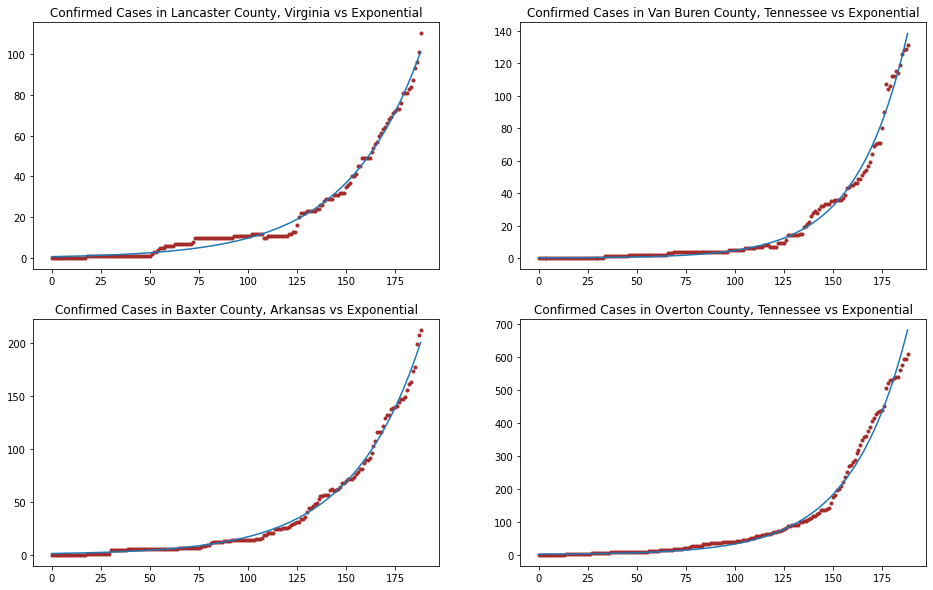

In [10]:
# The R^2 metrics divide the time series into several groups. Let's look at
# examples of each of these groups in turn.
#
# Show some example time series for which a single exponential curve
# has R^2 above 0.99
util.graph_examples(curves, ts_col_name, {"Exponential": curves["Exponential"]},
                    mask=stats['Exp_R^2'] >= r2_thresh)

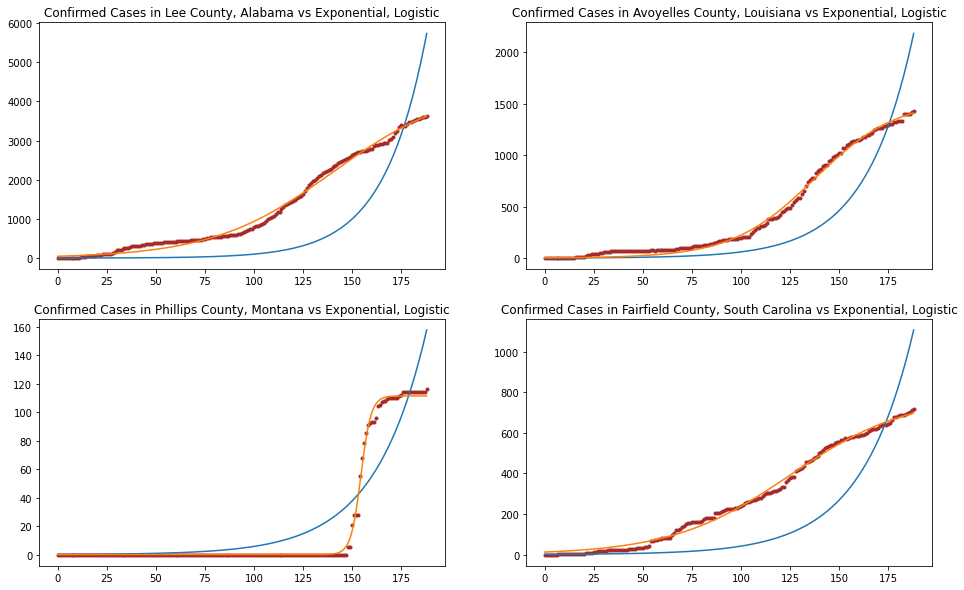

In [11]:
# Let's look at some examples where logistic growth (with a single
# instance of the logistic function) produces a good fit, while an
# exponential growth model does not.
mask = (stats['Log_R^2'] >= r2_thresh) & (stats['Exp_R^2'] < 0.95)
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=mask)

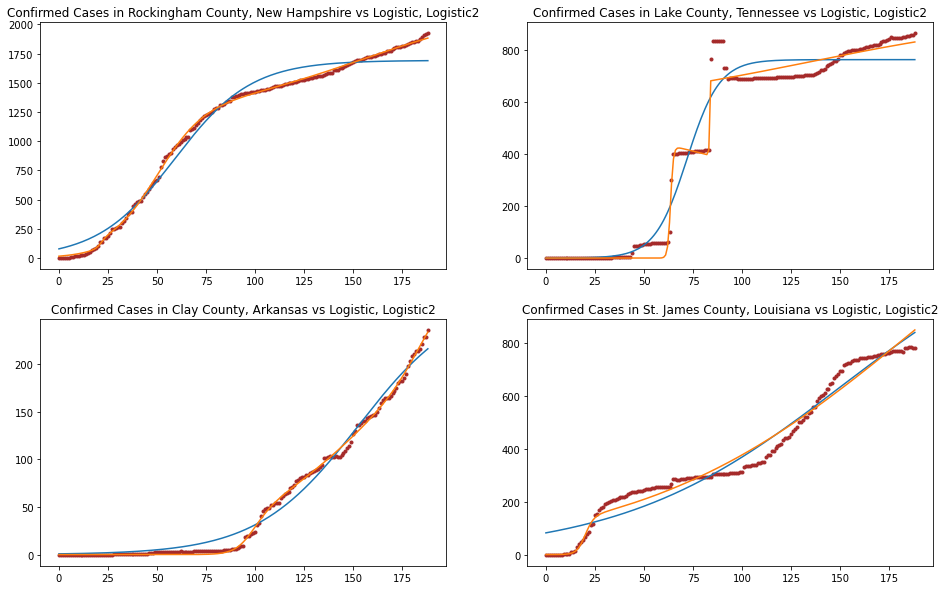

In [12]:
# Look at cases where a mixture of two logistic growth models explains
# the data better than a single logistic growth model.
mask = stats['Log2_R^2'] - stats['Log_R^2'] >= 0.01
#graph_examples(mask, {"Logistic": logistic, "Logistic2": logistic2}, num_to_pick=10)
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=mask)

In [13]:
# Many of these dual-logistic curves have low values for the rate of the
# second logistic function.
# Across the entire data set, what models have logistic rate2 near zero?
small_rate2_mask = (stats['Log2_R^2'] >= r2_thresh) & (params["Log2_Rate2"] < 5e-2)
params[small_rate2_mask][metadata_cols + [c for c in params.columns if c.startswith("Log2")]]

,State,County,Population,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,
1005,Alabama,Barbour,24686,576.932344,10.000000,188.999996,666.042293,0.043512,111.520015,29.052494,36.468221
1007,Alabama,Bibb,22394,676.448138,0.041137,142.909394,706.808941,0.036872,142.909261,10.000043,19.999971
1011,Alabama,Bullock,10101,778.428086,10.000000,189.000000,838.661310,0.014572,136.069713,69.522835,75.763220
1013,Alabama,Butler,19448,896.642037,10.000000,189.000000,959.843244,0.022062,88.986970,53.902450,61.646876
1021,Alabama,Chilton,44428,42781.039423,0.072563,135.426688,1358.189903,0.048670,146.158658,47.565548,56.523815
...,...,...,...,...,...,...,...,...,...,...,...
55135,Wisconsin,Waupaca,50990,1007.589593,0.150338,160.190722,1064.145489,0.043170,160.188593,9.999996,20.000102
55139,Wisconsin,Winnebago,171907,3050.102239,0.137066,93.585678,3516.710752,0.027864,183.698275,5.683887,54.012616
56005,Wyoming,Campbell,46341,423.123332,0.239312,188.993891,452.772518,0.023720,189.000000,13.516080,16.174590


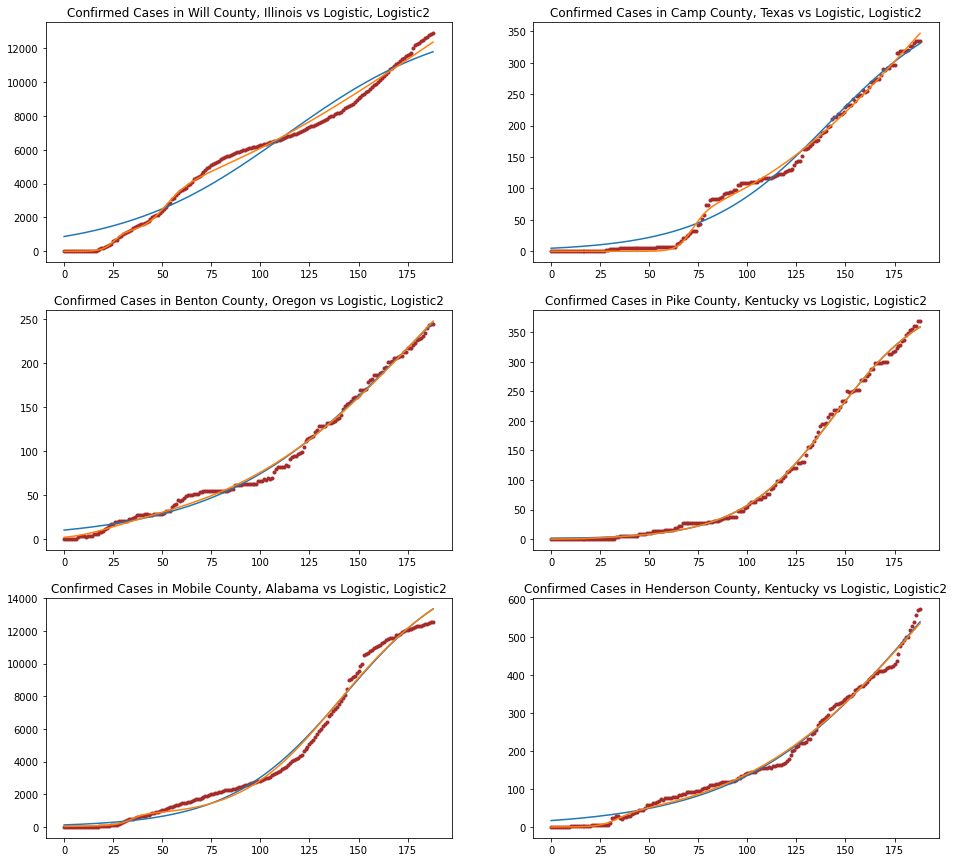

In [14]:
# Show some examples of these cases where Rate2 is small
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=small_rate2_mask,
                    num_to_pick=6)

In [15]:
# What about counties for which the rate for the single-logistic-curve fit
# is large?
large_rate_mask = (
    (stats['Log_R^2'] >= r2_thresh) 
    & (params["Log_Rate"] > 2e-1))
params[large_rate_mask][metadata_cols + [c for c in params.columns 
                                         if (c.startswith("Log")
                                             and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,
8109,Colorado,Saguache,6824,105.851207,0.200697,79.061338
12067,Florida,Lafayette,8422,1195.955442,0.548277,156.516876
30071,Montana,Phillips,3954,111.361651,0.386306,154.505558
48105,Texas,Crockett,3464,160.279117,0.213084,129.433180
48169,Texas,Garza,6229,101.650177,0.207988,128.416361
48283,Texas,La Salle,7520,363.298010,0.423771,128.678049
51750,Virginia,Radford,18249,699.031968,0.200071,172.314199


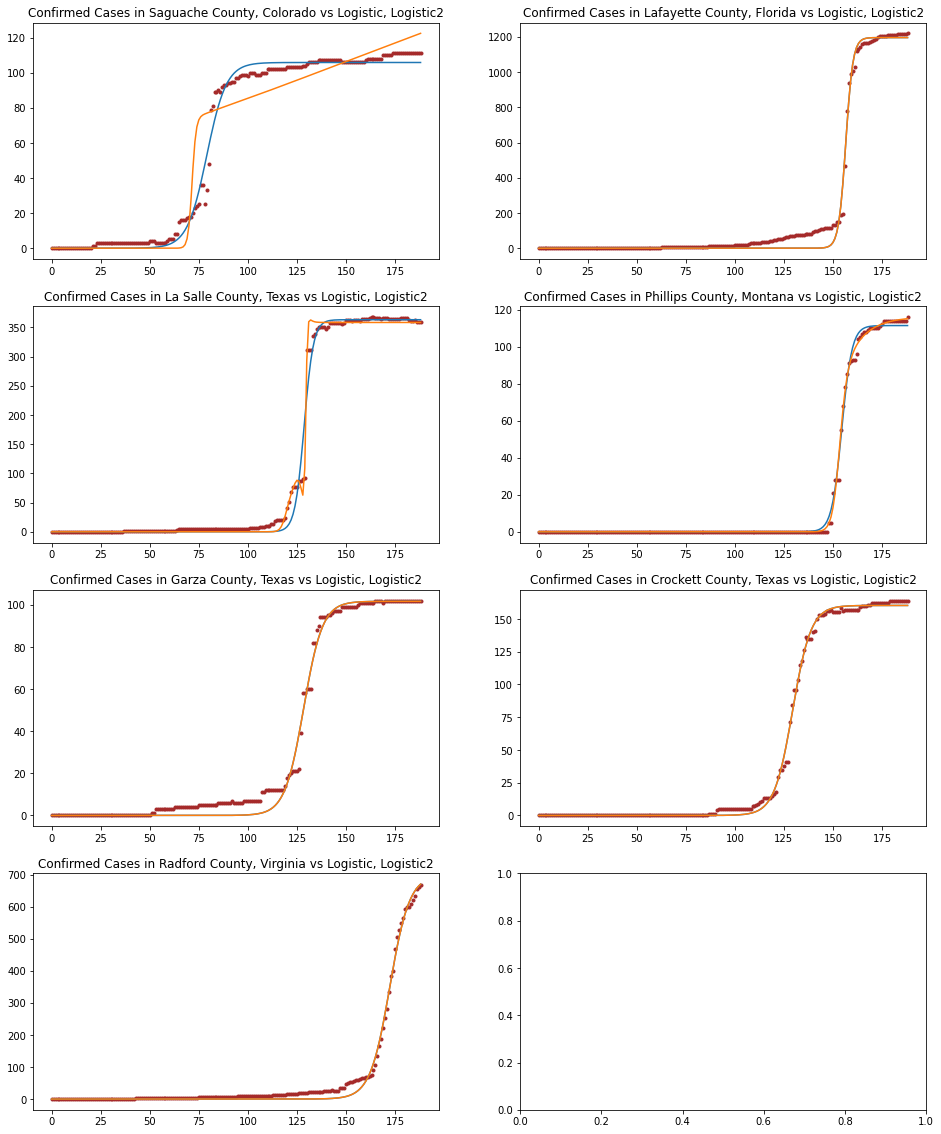

In [16]:
# Show some examples of these cases where Rate is large
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=large_rate_mask,
                    num_to_pick=10)

In [17]:
# What about counties for which the logistic curve fit is currently
# in the early phases of logistic growth
early_mask = (
    (stats['Log_R^2'] >= r2_thresh) & (params["Log_Offset"] > 80))
params[early_mask][metadata_cols + [c for c in params.columns 
                                    if (c.startswith("Log") and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,
1001,Alabama,Autauga,55869,1551.442009,0.040463,128.448136
1003,Alabama,Baldwin,223234,4805.747396,0.066776,136.974252
1005,Alabama,Barbour,24686,661.211562,0.044781,111.208761
1007,Alabama,Bibb,22394,705.162280,0.037003,142.758050
1009,Alabama,Blount,57826,1188.998104,0.054513,139.972227
...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,7688.154172,0.040126,149.596088
55135,Wisconsin,Waupaca,50990,1062.825220,0.043228,160.122269
55141,Wisconsin,Wood,72999,662.221414,0.054286,156.229990


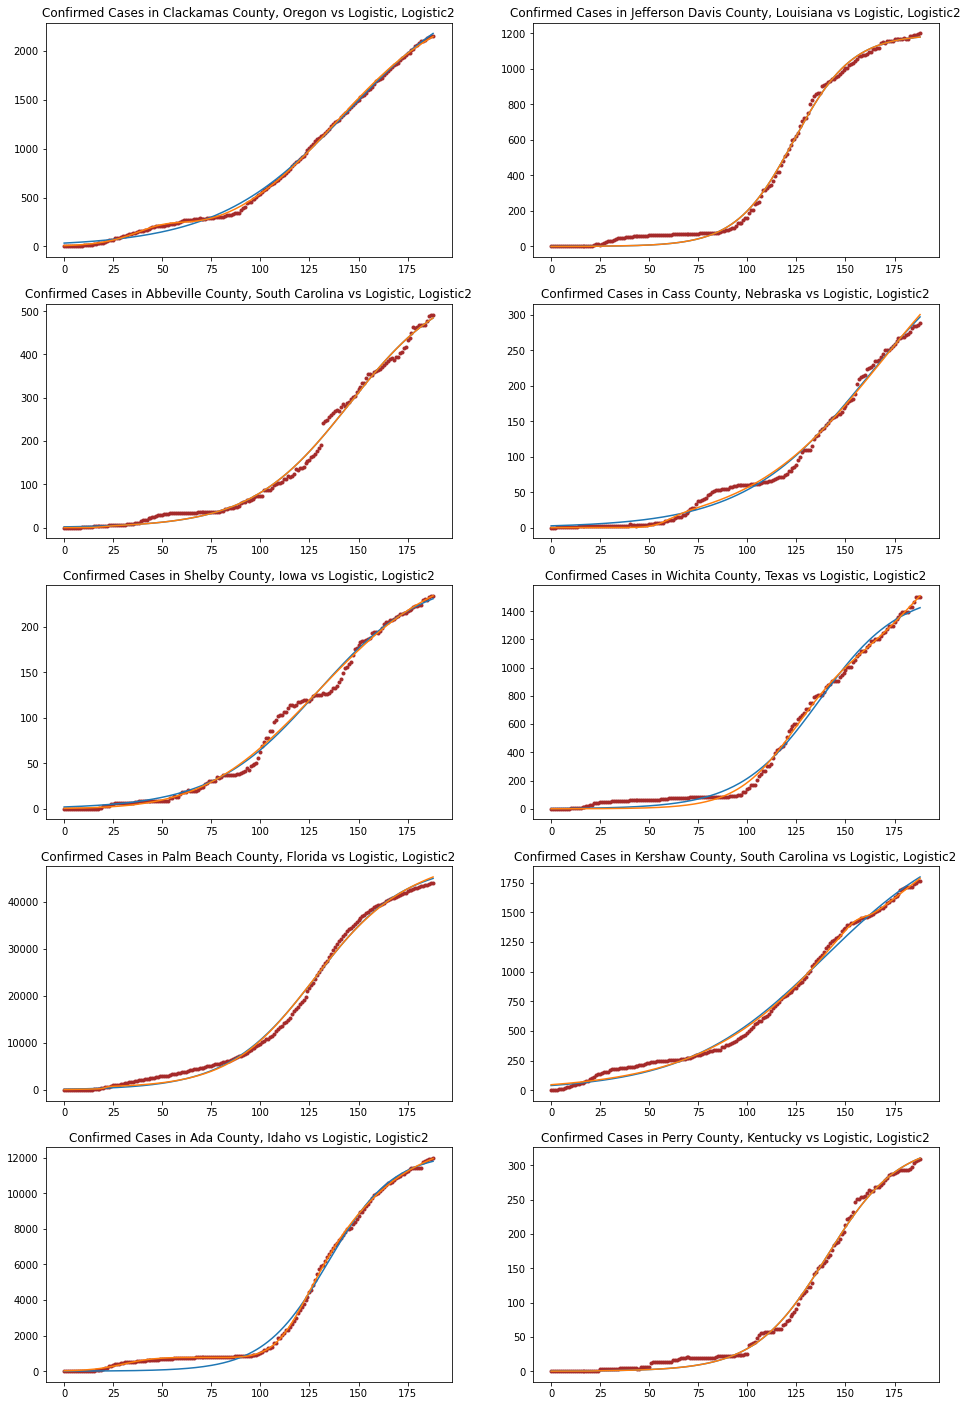

In [18]:
# Graphs of counties for which the logistic curve fit is currently
# in the early phases of logistic growth
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=early_mask,
                    num_to_pick=10)

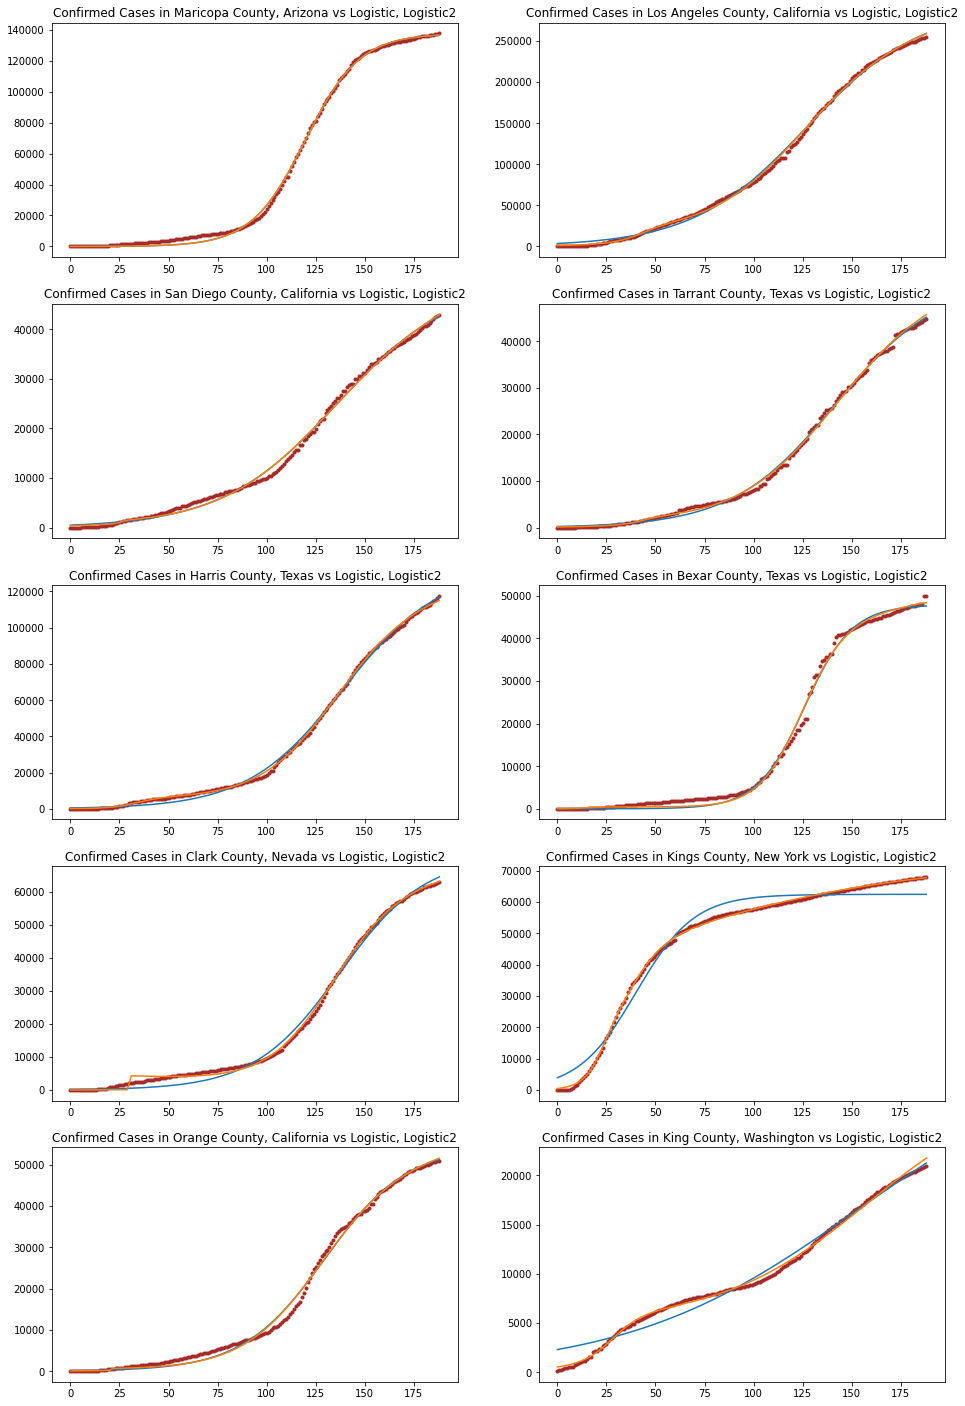

In [19]:
# What about populous counties?
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=curves["Population"] > 2e6,
                    num_to_pick=10)

In [20]:
# What time series are *not* explained by any of our curves?
non_fitting_mask = (stats["Exp_R^2"] < 0.99) & (stats["Log_R^2"] < 0.99) & (stats["Log2_R^2"] < 0.99)
stats[non_fitting_mask]

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1017,Alabama,Chambers,33254,-0.538468,0.974160,0.985068
1025,Alabama,Clarke,23622,0.707697,0.979769,0.979692
1037,Alabama,Coosa,10663,0.440139,0.976807,0.986217
1041,Alabama,Crenshaw,13772,0.722429,0.985111,0.985501
1059,Alabama,Franklin,31362,0.173806,0.981505,0.984888
...,...,...,...,...,...,...
56021,Wyoming,Laramie,99500,0.218682,0.979627,0.984767
56023,Wyoming,Lincoln,19830,0.837131,0.978800,0.978801
56025,Wyoming,Natrona,79858,0.574798,0.986552,0.989432


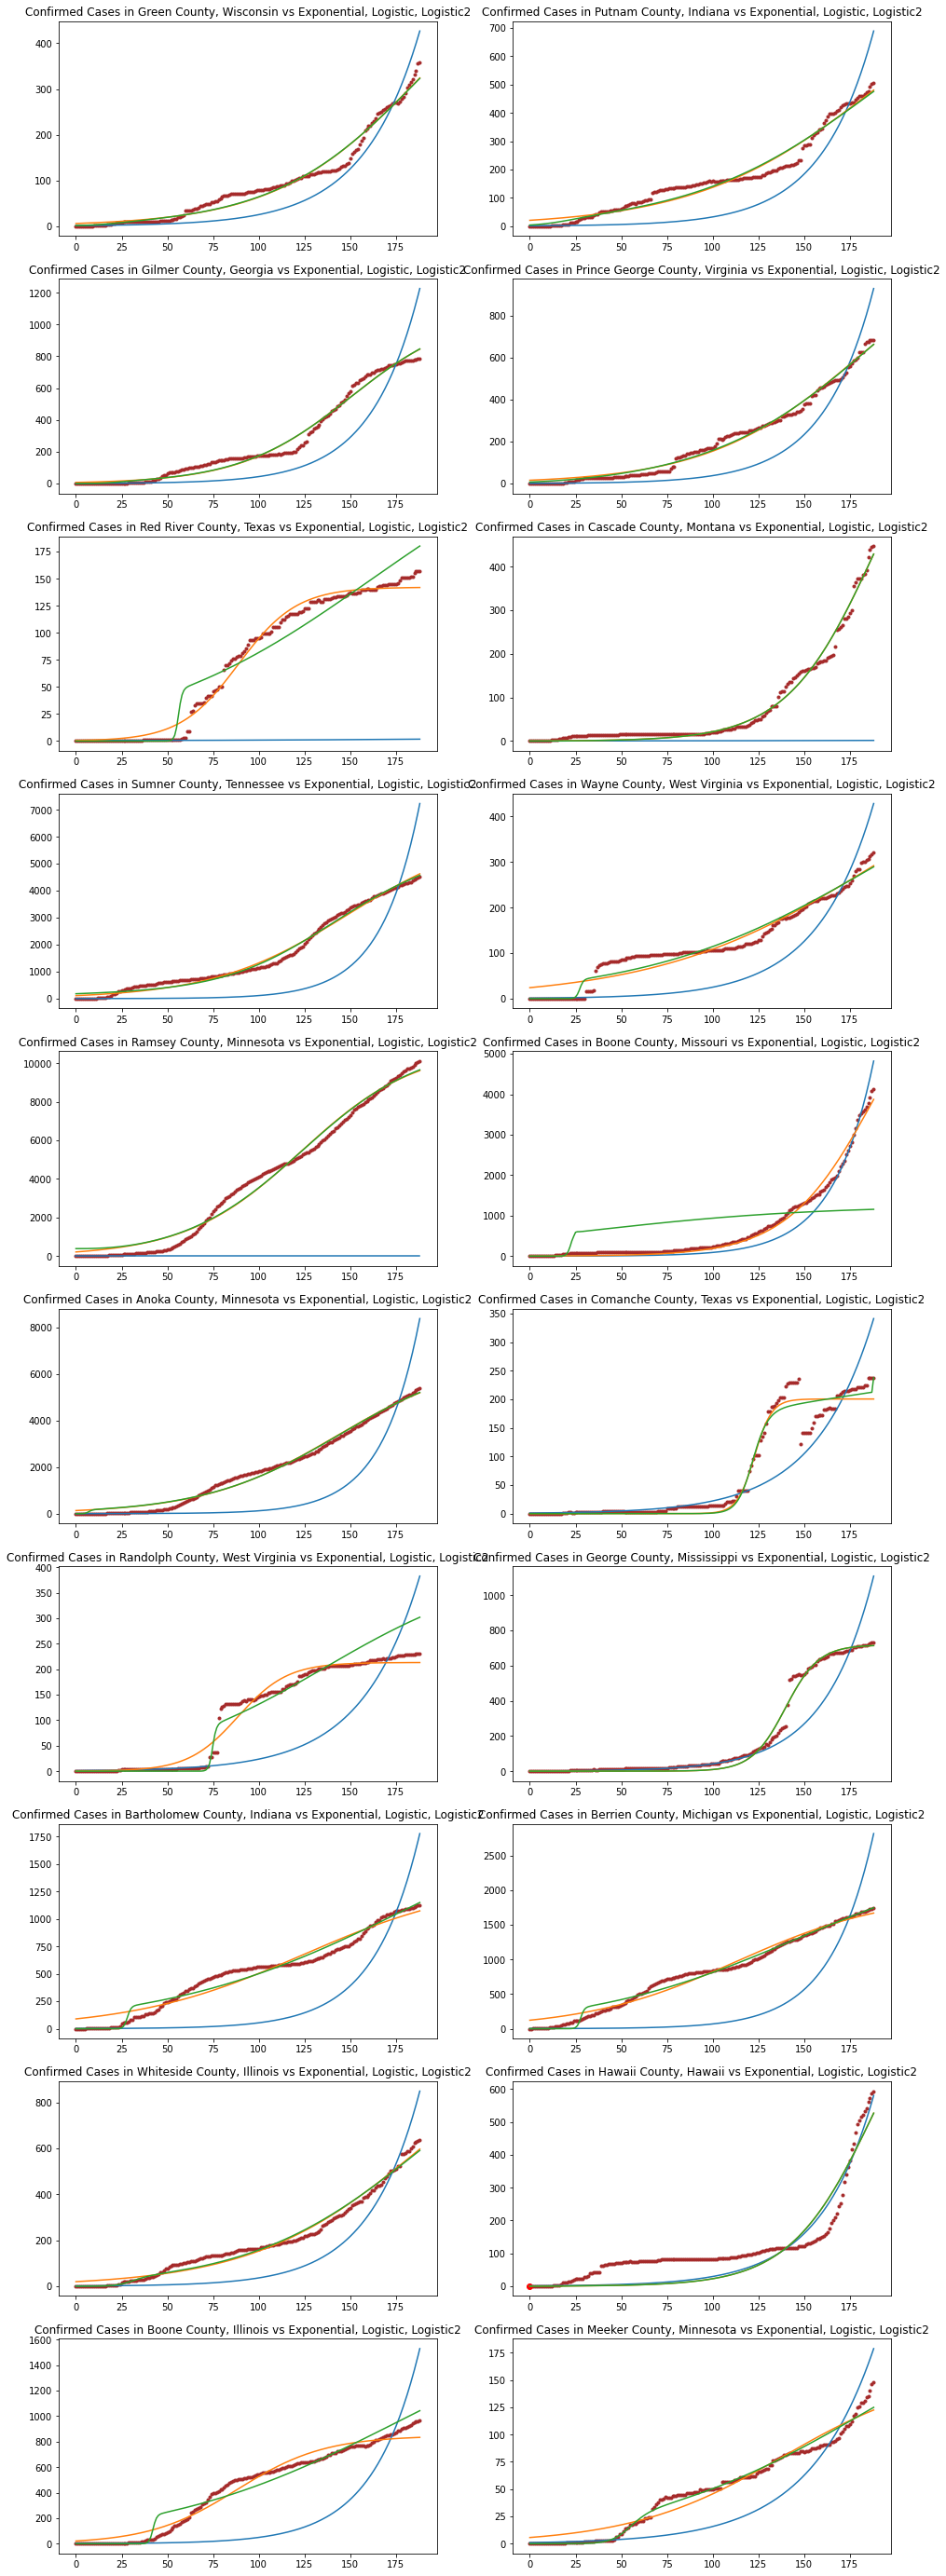

In [21]:
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=non_fitting_mask,
                    num_to_pick=20)